# Define lists of tiles to be processed in the gridded exposure step
- `WITHELEV`: Include information on exposure, elevation, and other boundaries.
- `WITHOUTELEV`: Include information on exposure and other boundaries, but not elevation.
- `CIAM`: Include information on elevation and other boundaries, but not exposure

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd
import numpy as np
import pandas as pd
import xarray as xr
from dask_gateway import GatewayCluster
from sliiders import settings as sset
from sliiders import spatial
from sliiders.io import open_dataarray, open_dataset, save

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [3]:
N_WORKERS = 16

In [4]:
cluster = GatewayCluster(profile="micro", idle_timeout=1800)
client = cluster.get_client()
cluster.scale(N_WORKERS)
cluster

In [5]:
lat_size = 43200
lon_size = 86400

lats_per_deg, lons_per_deg = int(lat_size / 180), int(lon_size / 360)

lon_chunk = int(lon_size / N_WORKERS)

In [6]:
client.wait_for_workers(N_WORKERS)

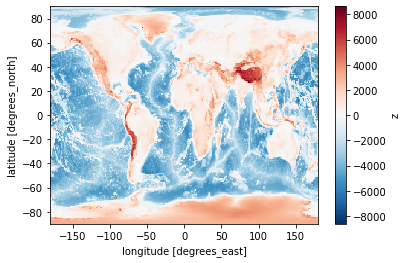

In [7]:
bdem = open_dataarray(sset.PATH_SRTM15_PLUS, chunks={"lat": lats_per_deg}).persist()

bdem_max = (
    bdem.coarsen(lat=lats_per_deg).max().coarsen(lon=lons_per_deg).max().compute()
)

bdem_min = (
    bdem.coarsen(lat=lats_per_deg).min().coarsen(lon=lons_per_deg).min().compute()
)

bdem_max.plot()

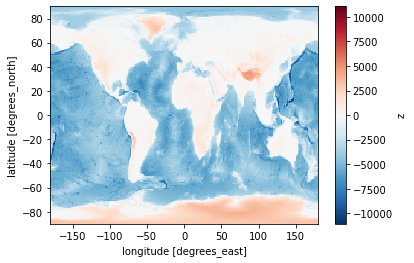

In [8]:
bdem_min.plot()

Double-check that the grid's spacing is regular over 1-degree tiles

In [9]:
assert len(np.unique(np.floor(bdem.lat.values[:lats_per_deg]))) == 1
assert len(np.unique(np.floor(bdem.lon.values[:lons_per_deg]))) == 1

assert (np.floor(bdem.lat.values)[::lats_per_deg] == np.arange(-90, 90)).sum() == 180
assert (np.floor(bdem.lon.values)[::lons_per_deg] == np.arange(-180, 180)).sum() == 360

Shut down cluster

In [10]:
client.close()
cluster.close()

## Organize tiles

In [11]:
max_tiles = bdem_max.to_dataframe(name="max").reset_index()
min_tiles = bdem_min.to_dataframe(name="min").reset_index()

tiles = pd.merge(max_tiles, min_tiles, on=["lat", "lon"])

tiles.index = pd.Index(spatial.get_tile_names(tiles, "lon", "lat"), name="tile_name")
tiles = gpd.GeoDataFrame(tiles, geometry=tiles.apply(spatial.get_degree_box, axis=1))

tiles["llat"] = np.floor(tiles["lat"])
tiles["llon"] = np.floor(tiles["lon"])

#### Determine whether each tile meets certain criteria, which will be used to define categories

Prepare tiles and category sets

In [12]:
def get_all_exp_tiles(exp, cell_size):
    """
    Get the list of CoastalDEM tiles included in an exposure dataset.

    Parameters
    ----------
    exp : :py:class:`pandas.DataFrame`
        Dataframe of exposure, containing ``lon`` and ``lat`` columns.
    Returns
    -------
    :py:class:`numpy.ndarray`
        1D array of unique 1-degree tile names

    """
    exp_tiles = (
        pd.DataFrame(
            spatial.grid_val_to_ix(
                spatial.grid_ix_to_val(
                    exp[["x_ix", "y_ix"]].values,
                    cell_size=cell_size,
                    lon_mask=[True, False],
                ),
                cell_size=1,
                lon_mask=[True, False],
            ),
            columns=["lon", "lat"],
        )
        .drop_duplicates()
        .astype(int)
    )
    lonnames = ("W" + exp_tiles.lon.astype(str).str[1:].str.zfill(3)).where(
        exp_tiles.lon < 0, "E" + exp_tiles.lon.astype(str).str.zfill(3)
    )
    latnames = ("S" + exp_tiles.lat.astype(str).str[1:].str.zfill(2)).where(
        exp_tiles.lat < 0, "N" + exp_tiles.lat.astype(str).str.zfill(2)
    )
    return (latnames + lonnames).values

In [13]:
exp_tiles = get_all_exp_tiles(
    pd.read_parquet(sset.PATH_EXPOSURE_ASSET_VALUE_BLENDED, columns=["x_ix", "y_ix"]),
    sset.ASSET_VALUE_GRID_WIDTH,
)

pop_tiles = get_all_exp_tiles(
    pd.read_parquet(sset.PATH_EXPOSURE_POP_INT, columns=[]).reset_index(),
    sset.POP_GRID_WIDTH,
)

coastaldem_tiles = [
    i.split("/")[-1][:-4] for i in sset.FS.glob(str(sset.DIR_COASTALDEM / "*.tif"))
]

Apply category logic

In [14]:
# define the elevation at which a non-coastalDEM tile must go below to have a chance of
# being below our maximum modeled sea level height (20m) after adjusting for local MDT.
# Also, define opposite value (minimum elev)
with open_dataset(sset.PATH_GEOG_MDT_RAW).mdt as mdt:
    ub = sset.HIGHEST_WITHELEV_EXPOSURE_METERS + np.ceil(mdt.max().item())
    lb = np.ceil(mdt.min().item())

In [15]:
# Tile is included in CoastalDEM
tiles["coastaldem"] = tiles.index.isin(coastaldem_tiles)

# Tile has non-0 asset-value or population
tiles["exp"] = tiles.index.isin(exp_tiles) | tiles.index.isin(pop_tiles)

# Tile is below the 60th parallel south (governed under the Antarctic Treaty System)
tiles["antarctica"] = tiles["lat"] < -60

# Tile includes elevations below a threshold that, when MSS datum conversion is applied
# has a chance of being low enough to be under our max modeled elev (20m). Does not
# apply to CoastalDEM tiles, for which we always model elevation
tiles["low_enough"] = tiles["min"] <= ub

# Tile includes elevations above a threshold that, when MSS datum conversion is applied
# has a chance of being high enough to contain land above current MSL. Only applies to
# tiles in which there is no exposure and that are not included in CoastalDEM
tiles["high_enough"] = tiles["max"] >= lb

Categorize tiles based on whether they are relevant to each group

In [16]:
# model elevation for all tiles that are coastaldem tiles or are low enough SRTM tiles
# and have some exposure (capital or pop)
tiles["WITHELEV"] = (tiles.low_enough | tiles.coastaldem) & tiles.exp

# All other tiles with capital or pop. Need to get all of these to capture all exposure
# for proper scaling to PWT and LANDSCAN values
tiles["WITHOUTELEV"] = tiles.exp & (~tiles.WITHELEV)

# All other tiles that need to have land/wetland area modeled in CIAM
tiles["CIAM"] = (
    (tiles["coastaldem"] | (tiles["high_enough"] & tiles["low_enough"]))
    & (~tiles.antarctica)
    & (~tiles.WITHELEV)
    & (~tiles.WITHOUTELEV)
)

Plot tile categories

<AxesSubplot:>

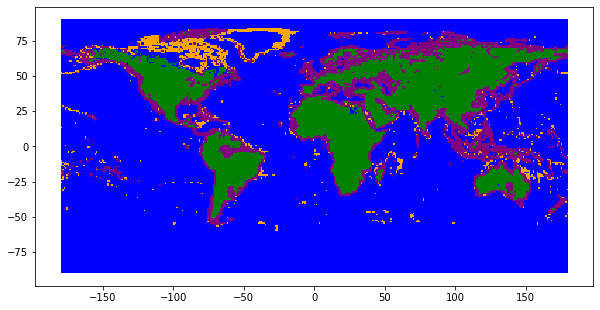

In [17]:
def get_color(tile):
    if tile["WITHELEV"]:
        return "purple"
    if tile["WITHOUTELEV"]:
        return "green"
    if tile["CIAM"]:
        return "orange"
    return "blue"


tiles["color"] = tiles.apply(get_color, axis=1)
tiles.plot(color=tiles["color"], figsize=(10, 10))

Transform booleans into categories

In [18]:
out = (
    pd.Series(
        np.where(
            tiles["WITHELEV"],
            "WITHELEV",
            np.where(
                tiles["WITHOUTELEV"],
                "WITHOUTELEV",
                np.where(tiles["CIAM"], "CIAM", None),
            ),
        ),
        index=tiles.index,
        name="PROCESSING_SET",
    )
    .dropna()
    .to_frame()
)

Save lists

In [19]:
save(out, sset.PATH_EXPOSURE_TILE_LIST)